# This is week 7 activities.
---
## Goal
In this in-class quiz, you will learn:

* **Convolutional Neural Network -- Using Convolutional Neural Network (CNN) for binary classification.**

We will take a W/Z jets v.s Quark jets to be an example.

The W/Z jets images are labeled to `0` and quark jets images are labeled to `1`.

Keras in TensorFlow 2: We will build a CNN network to classify W/Z jets v.s Quark jets into two classes.
Keras is a friendly package for beginner. You can easily build a sequential architecture for training.


Ref. [TensorFlow 2 quickstart for beginners](https://www.tensorflow.org/tutorials/quickstart/beginner)

Ref. [Keras](https://keras.io)

Ref. [Example of CNN in TensorFlow 2](https://www.tensorflow.org/tutorials/images/cnn)

Ref. [A Comprehensive Guide to Convolutional Neural Networks ](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

* **Is the training heathy? -- Learning curves will tell us.**

We can use learning curves to judge how healthy our model is.
Learning curves can show that our model is overfitting, underfitting or healthy.

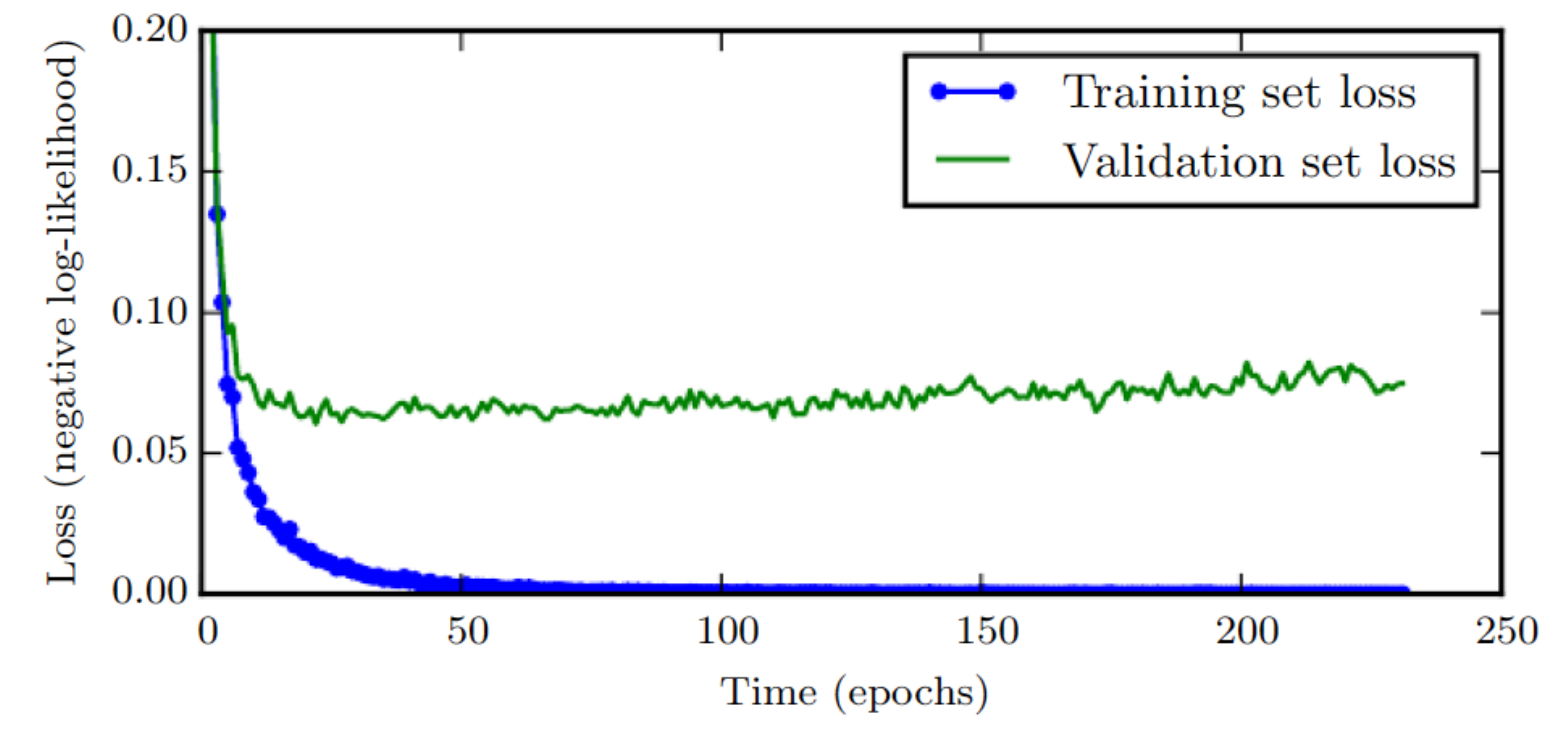
Resource: [Deep Learning: Chapter 7](https://www.deeplearningbook.org/contents/regularization.html)

Ref [Learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning))

---
* **Workflow:**
 
   i. Load Training Data     
   ii. Visualize images      
   iii. Build CNN which will contain (Conv2D -> MaxPooling -> Conv2D -> MaxPooling -> Dense(300) -> Dense(2))     
   iv. Fit the CNN Model (model.fit(X,Y))    
   v. Save Model (model.save("./model.h5"))     
   vi. Make a figure for learning curve.   
   vii. Load Model (load_model("./model.h5"))   
   viii. Evaluate Performance by Test Data : ROC, AUC


---
* **Data Description:**

In the `In_Class_Train`, `In_Class_Validation` and `In_Class_Test` folders, we have training, validation and test images data set in image base, respectively. 

In each folder, there is an dictionary file (e.g. `test_dict.csv` in `In_Class_Test`) to record the path and label for each image.

We have two kinds of images. One is W/Z jet image. The other is quark jet image.  
They are 1-channel images made by charged transverse momentum.   
The W/Z jets are labeled to `0` and quark jets images are labeled to `1`.

Each jet is clustered by anti-kt algorithm with R=0.8 and transverse momentum should be greater than 200 GeV.  
The resolution for jet image is 40X40 pixels and in 1.5RX1.5R range.   
Thesy also passed prerocessing: normalized and standardized.  
For further detail, you can find in references.

Ref. [Disentangling Boosted Higgs Boson Production Modes with Machine Learning](https://arxiv.org/abs/2009.05930)   
Ref. [Boosting H→bb¯ with Machine Learning](https://arxiv.org/abs/1807.10768)   
Ref. [Jet Algorithm](https://arxiv.org/pdf/1302.0260.pdf)   

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from sklearn.utils import shuffle
import time


# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K
from sklearn import metrics

print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname in os.listdir('/kaggle/input/phys591000-week07/'):
    print(dirname,"/")
    for filename in os.listdir('/kaggle/input/phys591000-week07/'+ dirname):
        print(filename)
    print("\n")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow Version is 2.4.1
Keras Version is 2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5782503349869728412
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15685569792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8913526767947672364
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Lab_Test /
Jet_Images_1
test_dict.csv


Lab_Validation /
Jet_Images_1
val_dict.csv


In_Class_Train /
Jet_Images_1
Jet_Images_6
Jet_Images_7
Jet_Images_5
Jet_Images_4
train_dict.csv
Jet_Images_2
Jet_Images_3


In_Class_Test /
Jet_Images_1
test_dict.csv


In_Class_Validation /
Jet_Images_1
val_dict.csv


Lab_Train /
Jet_Images_1
Jet_Images_6
Jet_Images_7
Jet_Images_5
Jet_Images_4
train_dict.csv
Jet_Images_2
Jet_Images_3




# Convolutional Neural Network

# Example 1 -- Load Data

In [2]:
"""
Our data are many jet images.
In each In_Class_XXX folder, we have a dictionary to record the path and label for each picture.
This cell demonstrates how to load images in "In_Class_Test"
We will load top 1000 events for an example.
Then check its composition.
"""
#########################################################################################

"""
Declare a common path
"""
path  = "/kaggle/input/phys591000-week07"

"""
Load a dictionary: "test_dict.csv" in the "In_Class_Test" folder.
"""
test_dict = pd.read_csv(path + "/In_Class_Test/test_dict.csv")
print("\n")
print("Top 10 event infomation")
print(test_dict.head(10))

"""
Load top 1,000 events in the "In_Class_Test" folder.
"x_test_jet" is our images and "target_test" is our labels.
"""
x_test_jet = []

for i in range(1000):
    x_jet_path = path + "/In_Class_Test/" + test_dict["Jet_Images"][i]
    x_jet_tmp = np.load(x_jet_path)["jet_images"]
    x_test_jet.append(x_jet_tmp)
    
        
x_test_jet = np.array(x_test_jet)       
        
target_test = test_dict["Y"][:1000]


"""
Check statistic balance for data
"""

print("\n")
print("There are {} W/Z jets in the test data set.".format(len(target_test[target_test==0])))
print("There are {} quark jets in the test data set.".format(len(target_test[target_test==1])))

"""
Transfrom our label into one-hot code
"""
target_test = to_categorical(np.array(target_test))


"""
Check data shape
"""
print("\n")
print("Test data shape: ",x_test_jet.shape)






Top 10 event infomation
                       Jet_Images  Y
0   Jet_Images_1/x_test_jet_1.npz  0
1   Jet_Images_1/x_test_jet_2.npz  1
2   Jet_Images_1/x_test_jet_3.npz  0
3   Jet_Images_1/x_test_jet_4.npz  0
4   Jet_Images_1/x_test_jet_5.npz  0
5   Jet_Images_1/x_test_jet_6.npz  1
6   Jet_Images_1/x_test_jet_7.npz  1
7   Jet_Images_1/x_test_jet_8.npz  0
8   Jet_Images_1/x_test_jet_9.npz  1
9  Jet_Images_1/x_test_jet_10.npz  0


There are 512 W/Z jets in the test data set.
There are 488 quark jets in the test data set.


Test data shape:  (1000, 1, 40, 40)


In [3]:
x_test_jet

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -0.01569454, -0.01441701, ..., -0.02026328,
          -0.01851882, -0.01630057],
         [ 0.        , -0.01292349, -0.01599289, ..., -0.01324957,
          -0.018295  , -0.01445282],
         ...,
         [ 0.        , -0.01388088, -0.01336397, ..., -0.01877315,
          -0.01922266, -0.01951717],
         [ 0.        , -0.01606581, -0.01754989, ..., -0.01358769,
          -0.01225736, -0.01097935],
         [ 0.        , -0.01685998, -0.01057091, ..., -0.01558235,
          -0.01293152, -0.01559804]]],


       [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -0.01569454, -0.01441701, ..., -0.02026328,
          -0.01851882, -0.01630057],
         [ 0.        , -0.01292349, -0.01599289, ..., -0.01324957,
          -0.018295  , -0.01445282],
         ...,
         [ 0.        , -0.013880

# Exercise 1 -- Load Data

training : validation  = 10,000 : 1,000 

In [4]:
"""
In the example, we demonstrated how to load data in the "In_Class_Test" folder followed dictionary "test_dict.csv"
Now, please load data and label in the "In_Class_Train" folder and in the "In_Class_Validation" folder.
Please load top 10,000 data in "In_Class_Train" folder.
Please load top 1,000 data in "In_Class_Validation" folder.
Check statistic balance for both data set
"""
################################################################################################################
#Your code in this section


"""
Declare a common path
"""
path  = "/kaggle/input/phys591000-week07"

"""
Load a dictionary: "train_dict.csv" in the "In_Class_Train" folder.
"""
train_dict =pd.read_csv(path + "/In_Class_Train/train_dict.csv")
print("\n")
print("Top 10 event infomation")
print(train_dict.head(10))



"""
Load a dictionary: "val_dict.csv" in the "In_Class_Validation" folder.
"""
val_dict = pd.read_csv(path + "/In_Class_Validation/val_dict.csv")
print("\n")
print("Top 10 event infomation")
print(val_dict.head(10))



"""
Load top 10,000 events in the "In_Class_Train" folder.
"x_train_jet" is our images and "target_train" is our labels.
"""
x_train_jet = []

for i in range(10000):
    x_jet_path = path + "/In_Class_Train/" + train_dict["Jet_Images"][i]
    x_jet_tmp = np.load(x_jet_path)["jet_images"]
    x_train_jet.append(x_jet_tmp)





x_train_jet = np.array(x_train_jet)       
        
target_train = train_dict["Y"][:10000]



"""
Load top 1,000 events in the "In_Class_Validation" folder.
"x_val_jet" is our images and "target_val" is our labels.
"""
x_val_jet = []

for i in range(1000):
    x_jet_path = path + "/In_Class_Validation/" + val_dict["Jet_Images"][i]
    x_jet_tmp = np.load(x_jet_path)["jet_images"]
    x_val_jet.append(x_jet_tmp)




x_val_jet = np.array(x_val_jet)       
        
target_val = val_dict["Y"][:1000]



"""
Check statistic balance for data
"""
print("\n")
print("There are {} W/Z jets in the training data set.".format(len(target_train[target_train==0])))
print("There are {} quark jets in the training data set.".format(len(target_train[target_train==1])))





"""
Transfrom labels into one-hot code
"""
target_train = to_categorical(np.array(target_train))
target_val = to_categorical(np.array(target_val))




"""
Check data shape
"""
print("\n")
print("Training data shape: ",x_train_jet.shape)
print("\n")
print("Validation data shape: ",x_val_jet.shape)


################################################################################################################
# Check your result is correct or not.
assert len(target_train) == 10000, print(f"Your array is not match the request.")
assert target_val[100][0] == 1.0, print(f"Your array is not match the request.")
print("Quiz 01 is passed!")



Top 10 event infomation
                        Jet_Images  Y
0   Jet_Images_1/x_train_jet_1.npz  1
1   Jet_Images_1/x_train_jet_2.npz  0
2   Jet_Images_1/x_train_jet_3.npz  1
3   Jet_Images_1/x_train_jet_4.npz  1
4   Jet_Images_1/x_train_jet_5.npz  0
5   Jet_Images_1/x_train_jet_6.npz  1
6   Jet_Images_1/x_train_jet_7.npz  1
7   Jet_Images_1/x_train_jet_8.npz  1
8   Jet_Images_1/x_train_jet_9.npz  1
9  Jet_Images_1/x_train_jet_10.npz  1


Top 10 event infomation
                      Jet_Images  Y
0   Jet_Images_1/x_val_jet_1.npz  0
1   Jet_Images_1/x_val_jet_2.npz  1
2   Jet_Images_1/x_val_jet_3.npz  1
3   Jet_Images_1/x_val_jet_4.npz  0
4   Jet_Images_1/x_val_jet_5.npz  0
5   Jet_Images_1/x_val_jet_6.npz  0
6   Jet_Images_1/x_val_jet_7.npz  1
7   Jet_Images_1/x_val_jet_8.npz  1
8   Jet_Images_1/x_val_jet_9.npz  1
9  Jet_Images_1/x_val_jet_10.npz  1


There are 4918 W/Z jets in the training data set.
There are 5082 quark jets in the training data set.


Training data shape:  (10000

# Example 2 -- Visualize a W/Z Jet Image and a Quark Jet Image

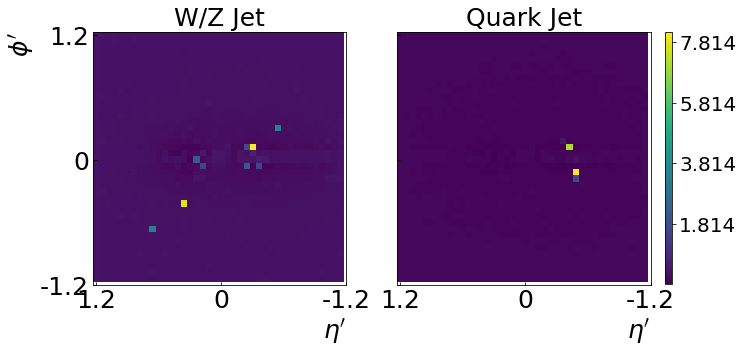

In [5]:
"""
Our data are many jet images.
This cell demonstrates how to load images in "In_Class_Train" for visualization.
We will load a W/Z jet image and a quark image for an example.
"""
################################################################################################################

"""
Declare a common path
"""
path  = "/kaggle/input/phys591000-week07"


"""
Load a dictionary: "train_dict.csv" in the "In_Class_Train" folder.
"""
train_dict = pd.read_csv(path + "/In_Class_Train/train_dict.csv")



WZ_jet = []
quark_jet = []
for i in range(100):
    x_jet_path = path + "/In_Class_Train/" + train_dict["Jet_Images"][i]
    x_jet_tmp = np.load(x_jet_path)["jet_images"]
    if train_dict["Y"][i] == 0:    # Find W/Z jet
        WZ_jet.append(x_jet_tmp)
    if train_dict["Y"][i] == 1:    # Find Quark jet
        quark_jet.append(x_jet_tmp)

    if len(WZ_jet) == 1 and len(quark_jet) == 1:
        break
        


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))


eventimage_average_0 = np.average(WZ_jet,axis=0)[0]


axes[0].imshow(eventimage_average_0,
               vmin=round(np.min(eventimage_average_0),3),
               vmax=round(np.max(eventimage_average_0),3),
               cmap="viridis",
               origin='upper')

axes[0].set_title("W/Z Jet", fontsize=25)

axes[0].set_yticks([0,20,40])
axes[0].set_yticklabels(["1.2","0","-1.2"], fontsize=25, rotation=0)
axes[0].tick_params(axis='y', direction="in")
axes[0].set_ylabel("$\phi'$", fontsize=25, horizontalalignment='right',y=1)


axes[0].set_xticks([0,20,40])
axes[0].set_xticklabels(["1.2","0","-1.2"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
axes[0].set_xlabel("$\eta'$", fontsize=25,horizontalalignment='right',x=1)
axes[0].tick_params(axis='x', direction="in")


eventimage_average_1 = np.average(quark_jet,axis=0)[0]


im = axes[1].imshow(eventimage_average_1,
               vmin=round(np.min(eventimage_average_1),3),
               vmax=round(np.max(eventimage_average_1),3),
               cmap="viridis",
               origin='upper')

axes[1].set_title("Quark Jet", fontsize=25)

axes[1].set_yticks([0,20,40])
axes[1].set_yticklabels(["","",""], fontsize=25, rotation=0)
axes[1].tick_params(axis='y', direction="in")

axes[1].set_xticks([0,20,40])
axes[1].set_xticklabels(["1.2","0","-1.2"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
axes[1].set_xlabel("$\eta'$", fontsize=25,horizontalalignment='right',x=1)
axes[1].tick_params(axis='x', direction="in")

cb_ax = fig.add_axes([0.92, 0.415, 0.01, 0.175])
cbar = fig.colorbar(im, cax=cb_ax)
# #  set the colorbar ticks and tick labels
cbar.set_ticks(np.arange(min(np.min(eventimage_average_0),np.min(eventimage_average_1)), 
                         max(np.max(eventimage_average_0),np.max(eventimage_average_1)), 2))
cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# Exercise 2 -- Visualize Averaged 1000 W/Z Jet Image and Averaged 1000 Quark Jet Image

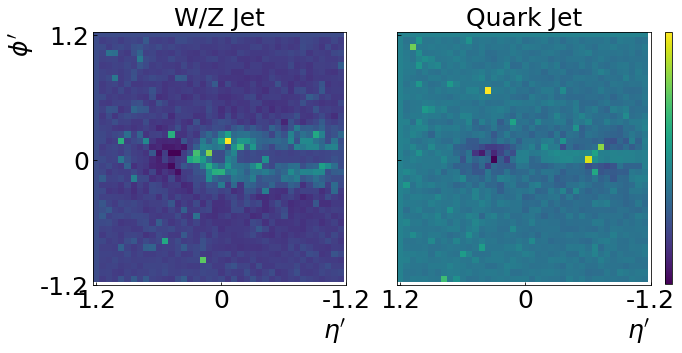

Please rise your hand to let TA check your figures.
Quiz 02 is passed!


In [6]:
"""
Please load 1000 W/Z jet image and 1000 quark image from "In_Class_Train". 
Then take average for these 1000 W/Z jet images and take average for these 1000 quark jet images.
Make two figures for averaged W/Z jet image and averaged quark image.
"""
################################################################################################################
#Your code in this section
"""
Declare a common path
"""
path  = "/kaggle/input/phys591000-week07"


"""
Load a dictionary: "train_dict.csv" in the "In_Class_Train" folder.
"""
train_dict = pd.read_csv(path + "/In_Class_Train/train_dict.csv")

##
WZ_jet = []
quark_jet = []

for i in range(10000):
    x_jet_path = path + "/In_Class_Train/" + train_dict["Jet_Images"][i]
    x_jet_tmp = np.load(x_jet_path)["jet_images"]
    if train_dict["Y"][i] == 0:    # Find W/Z jet
        WZ_jet.append(x_jet_tmp)
    if train_dict["Y"][i] == 1:    # Find Quark jet
        quark_jet.append(x_jet_tmp)

    if len(WZ_jet) == 1000 and len(quark_jet) == 1000:
        break
        


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))


eventimage_average_0 = np.average(WZ_jet,axis=0)[0]


axes[0].imshow(eventimage_average_0,
               vmin=round(np.min(eventimage_average_0),3),
               vmax=round(np.max(eventimage_average_0),3),
               cmap="viridis",
               origin='upper')

axes[0].set_title("W/Z Jet", fontsize=25)

axes[0].set_yticks([0,20,40])
axes[0].set_yticklabels(["1.2","0","-1.2"], fontsize=25, rotation=0)
axes[0].tick_params(axis='y', direction="in")
axes[0].set_ylabel("$\phi'$", fontsize=25, horizontalalignment='right',y=1)


axes[0].set_xticks([0,20,40])
axes[0].set_xticklabels(["1.2","0","-1.2"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
axes[0].set_xlabel("$\eta'$", fontsize=25,horizontalalignment='right',x=1)
axes[0].tick_params(axis='x', direction="in")


eventimage_average_1 = np.average(quark_jet,axis=0)[0]


im = axes[1].imshow(eventimage_average_1,
               vmin=round(np.min(eventimage_average_1),3),
               vmax=round(np.max(eventimage_average_1),3),
               cmap="viridis",
               origin='upper')

axes[1].set_title("Quark Jet", fontsize=25)

axes[1].set_yticks([0,20,40])
axes[1].set_yticklabels(["","",""], fontsize=25, rotation=0)
axes[1].tick_params(axis='y', direction="in")

axes[1].set_xticks([0,20,40])
axes[1].set_xticklabels(["1.2","0","-1.2"], fontsize=25, rotation=0, verticalalignment='top', horizontalalignment="center")
axes[1].set_xlabel("$\eta'$", fontsize=25,horizontalalignment='right',x=1)
axes[1].tick_params(axis='x', direction="in")

cb_ax = fig.add_axes([0.92, 0.415, 0.01, 0.175])
cbar = fig.colorbar(im, cax=cb_ax)
# #  set the colorbar ticks and tick labels
cbar.set_ticks(np.arange(min(np.min(eventimage_average_0),np.min(eventimage_average_1)), 
                         max(np.max(eventimage_average_0),np.max(eventimage_average_1)), 2))
cbar.ax.tick_params(labelsize=20)

plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()






##


################################################################################################################
# Check your result is correct or not.
print("Please rise your hand to let TA check your figures.")
print("Quiz 02 is passed!")

# Example 3 -- Bulid a CNN Architecture 

Sequential ->   
one 2D Convolutional layer (filters=32, kernel_size=(5, 5), strides=(1, 1)) ->   
MaxPooling layer (pool_size=(2, 2), strides=(2, 2)) ->   
Flatten ->   
Dense layer with 300 neurons ->   
Output Dense layer with 2 neurons


"relu" will be activation function for each hidden layer, and "softmax" will be the activation function for output layer.   
optimizer: Adadelta    
loss function : categorical_crossentropy

In [7]:
"""
Model Buliding
Here, we will demonstrate a simple Convolutional Neuron Network.
The architecture will contain:
one 2D Convolutional layer -> MaxPooling layer -> Flatten -> Dense layer with 300 neurons -> Output Dense layer with 2 neurons
The optimizer is  Adadelta and the loss function is categorical_crossentropy.
"""
#########################################################################################


"""
Declare the Input Shape
"""
input_shape = (1,40,40)


"""
Create a Sequential Model
"""
model_jet = Sequential(name = 'Sequential_for_jet')


"""
Add a "Conv2D" Layer into the Sequential Model
"""
model_jet.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 data_format='channels_first',
#                data_format='channels_last',
                input_shape=input_shape, 
                name = 'jet'))

"""
Add a "MaxPooling2D" Layer into the Sequential Model
"""
model_jet.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2),
                           data_format='channels_first', 
#                            data_format='channels_last',
                           name = 'jet_MaxPooling_1'))

"""
Flatten
"""
model_jet.add(Flatten(name = 'jet_flatten'))


"""
Put Output from Flatten Layer into "Dense" Layer with 300 neurons
"""
model_jet.add(Dense(300, activation='relu', name = 'jet_dense_1'))


"""
Add Output "Dense" Layer with 2 neurons into the Sequential Model
"""
model_jet.add(Dense(2, activation='softmax', name = 'jet_dense_2'))


"""
Declare the Optimizer
"""
model_opt = keras.optimizers.Adadelta()


"""
Compile Model
"""
model_jet.compile(loss="categorical_crossentropy",
#                    loss = "binary_crossentropy",
                   optimizer=model_opt,
                   metrics=["accuracy","mse"])

"""
Print Architecture
"""
model_jet.summary()


#########################################################################################

Model: "Sequential_for_jet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
jet (Conv2D)                 (None, 32, 36, 36)        832       
_________________________________________________________________
jet_MaxPooling_1 (MaxPooling (None, 32, 18, 18)        0         
_________________________________________________________________
jet_flatten (Flatten)        (None, 10368)             0         
_________________________________________________________________
jet_dense_1 (Dense)          (None, 300)               3110700   
_________________________________________________________________
jet_dense_2 (Dense)          (None, 2)                 602       
Total params: 3,112,134
Trainable params: 3,112,134
Non-trainable params: 0
_________________________________________________________________


# Exercise 3 -- Bulid a CNN Architecture 

Sequential ->
one 2D Convolutional layer (filters=32, kernel_size=(5, 5), strides=(1, 1)) ->   
MaxPooling layer (pool_size=(2, 2), strides=(2, 2)) ->   
ne 2D Convolutional layer (filters=32, kernel_size=(5, 5), strides=(1, 1)) ->   
MaxPooling layer (pool_size=(2, 2), strides=(2, 2)) ->   
Flatten ->    
Dense layer with 300 neurons ->   
Output Dense layer with 2 neurons    


"relu" will be activation function for each hidden layer, and "softmax" will be the activation function for output layer.   
optimizer: Adadelta    
loss function : categorical_crossentropy

In [8]:
"""
Your Turn: Model Buliding
Please construct an architecture.
The architecture will contain:

Sequential ->
one 2D Convolutional layer (filters=32, kernel_size=(5, 5), strides=(1, 1)) ->   
MaxPooling layer (pool_size=(2, 2), strides=(2, 2)) ->   
ne 2D Convolutional layer (filters=32, kernel_size=(5, 5), strides=(1, 1)) ->   
MaxPooling layer (pool_size=(2, 2), strides=(2, 2)) ->   
Flatten ->    
Dense layer with 300 neurons ->   
Output Dense layer with 2 neurons   

Please let the optimizer be Adadelta and the loss function is categorical_crossentropy.
"""
################################################################################################################
#Your code in this section

"""
Declare the Input Shape
"""
input_shape = (1,40,40)



"""
Create a Sequential Model
"""
model_jet_ex = Sequential(name = 'Sequential_for_jet')





"""
Add a "Conv2D" Layer into the Sequential Model
"""

model_jet_ex.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 data_format='channels_first',
#                data_format='channels_last',
                input_shape=input_shape, 
                name = 'jet'))






"""
Add a "MaxPooling2D" Layer into the Sequential Model
"""
model_jet_ex.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2),
                           data_format='channels_first', 
#                            data_format='channels_last',
                           name = 'jet_MaxPooling_1'))








"""
Add a "Conv2D" Layer into the Sequential Model
"""

model_jet_ex.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 data_format='channels_first',
#                data_format='channels_last',
                input_shape=input_shape, 
                name = 'jet2'))






"""
Add a "MaxPooling2D" Layer into the Sequential Model
"""

model_jet_ex.add(MaxPooling2D(pool_size=(2, 2), 
                           strides=(2, 2),
                           data_format='channels_first', 
#                            data_format='channels_last',
                           name = 'jet_MaxPooling_2'))







"""
Flatten
"""

model_jet_ex.add(Flatten(name = 'jet_flatten'))




"""
Put Output from Flatten Layer into "Dense" Layer with 300 neurons
"""

model_jet_ex.add(Dense(300, activation='relu', name = 'jet_dense_1'))




"""
Add Output "Dense" Layer with 2 neurons into the Sequential Model
"""

model_jet_ex.add(Dense(2, activation='softmax', name = 'jet_dense_2'))




"""
Define the Optimizer
"""

model_opt = keras.optimizers.Adadelta()

"""
Compile Model
"""

model_jet_ex.compile(loss="categorical_crossentropy",
#                    loss = "binary_crossentropy",
                   optimizer=model_opt,
                   metrics=["accuracy","mse"])





"""
Print Architecture
"""
model_jet_ex.summary()




################################################################################################################
# Check your result is correct or not.
print("Please rise your hand to let TA check your architecture!!")
print("Quiz 03 is passed!")

Model: "Sequential_for_jet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
jet (Conv2D)                 (None, 32, 36, 36)        832       
_________________________________________________________________
jet_MaxPooling_1 (MaxPooling (None, 32, 18, 18)        0         
_________________________________________________________________
jet2 (Conv2D)                (None, 32, 14, 14)        25632     
_________________________________________________________________
jet_MaxPooling_2 (MaxPooling (None, 32, 7, 7)          0         
_________________________________________________________________
jet_flatten (Flatten)        (None, 1568)              0         
_________________________________________________________________
jet_dense_1 (Dense)          (None, 300)               470700    
_________________________________________________________________
jet_dense_2 (Dense)          (None, 2)          

# Example 4 -- Model Training

In [9]:
"""
Fit model
"""
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
################################################################################################################


"""
Model Training
"""
History_jet = model_jet.fit( x_train_jet, target_train,
               validation_data= (x_val_jet, target_val),
               batch_size=512,
               epochs=50,
               verbose=1
              )


"""
Save Model
"""
model_jet.save("./model_jet.h5")


#########################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\n")
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Wed Apr 07 05:13:36 2021
Epoch 1/50
20/20 [==============================] - 4s 40ms/step - loss: 0.7031 - accuracy: 0.4879 - mse: 0.2534 - val_loss: 0.6938 - val_accuracy: 0.4810 - val_mse: 0.2500
Epoch 2/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6981 - accuracy: 0.5010 - mse: 0.2512 - val_loss: 0.6904 - val_accuracy: 0.4880 - val_mse: 0.2484
Epoch 3/50
20/20 [==============================] - 0s 12ms/step - loss: 0.6970 - accuracy: 0.4898 - mse: 0.2507 - val_loss: 0.6875 - val_accuracy: 0.4980 - val_mse: 0.2470
Epoch 4/50
20/20 [==============================] - 0s 11ms/step - loss: 0.6951 - accuracy: 0.5043 - mse: 0.2495 - val_loss: 0.6849 - val_accuracy: 0.5000 - val_mse: 0.2458
Epoch 5/50
20/20 [==============================] - 0s 11ms/step - loss: 0.6883 - accuracy: 0.5154 - mse: 0.2471 - val_loss: 0.6826 - val_accuracy: 0.5060 - val_mse: 0.2447
Epoch 6/50
20/20 [==============================] - 0s 11ms/step - loss: 0.6850 - accuracy: 0.5144 - mse: 0.24

# Exercise 4 -- Model Training

In [10]:
"""
Please follow Example 4 to train your model which is prepared in the Excerise 3.
"""
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
################################################################################################################
#Your code in this section



"""
Model Training
"""
History_jet_ex = model_jet_ex.fit( x_train_jet, target_train,
               validation_data= (x_val_jet, target_val),
               batch_size=512,
               epochs=50,
               verbose=1
              )








"""
Save Model
"""
model_jet_ex.save("./model_jet_ex.h5")



################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\n")
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))
################################################################################################################
# Check your result is correct or not.
print("Please rise your hand to let TA check your result!!")
print("Quiz 04 is passed!")

Wed Apr 07 05:13:52 2021
Epoch 1/50
20/20 [==============================] - 1s 23ms/step - loss: 0.8245 - accuracy: 0.5109 - mse: 0.2912 - val_loss: 0.8371 - val_accuracy: 0.4970 - val_mse: 0.2982
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.8110 - accuracy: 0.5039 - mse: 0.2907 - val_loss: 0.8225 - val_accuracy: 0.4990 - val_mse: 0.2941
Epoch 3/50
20/20 [==============================] - 0s 17ms/step - loss: 0.8131 - accuracy: 0.5061 - mse: 0.2869 - val_loss: 0.8092 - val_accuracy: 0.4980 - val_mse: 0.2903
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 0.7918 - accuracy: 0.5068 - mse: 0.2836 - val_loss: 0.7970 - val_accuracy: 0.4970 - val_mse: 0.2866
Epoch 5/50
20/20 [==============================] - 0s 14ms/step - loss: 0.7860 - accuracy: 0.5052 - mse: 0.2814 - val_loss: 0.7858 - val_accuracy: 0.4980 - val_mse: 0.2831
Epoch 6/50
20/20 [==============================] - 0s 13ms/step - loss: 0.7830 - accuracy: 0.5163 - mse: 0.27

# Example 5 -- Make a Learning Curve
---
`History_jet.history.keys()` can show contents in the `History_jet`.   

We will use "loss" and "val_loss" to draw a learning curve.



Wed Apr 07 05:14:07 2021
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


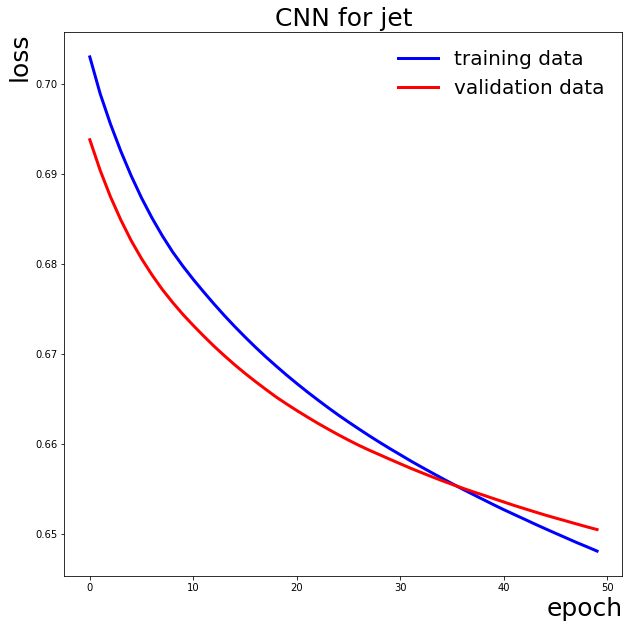



Time Cost : 0.0030 min


In [11]:
"""
Plot Learning Curve
"""
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
################################################################################################################

print(History_jet.history.keys())


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(History_jet.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History_jet.history["val_loss"], label='validation data',c='red',linewidth = 3)

plt.title("CNN for jet", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

#########################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\n")
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

# Exercise 5  -- Make a Learning Curve

Wed Apr 07 05:14:08 2021
dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


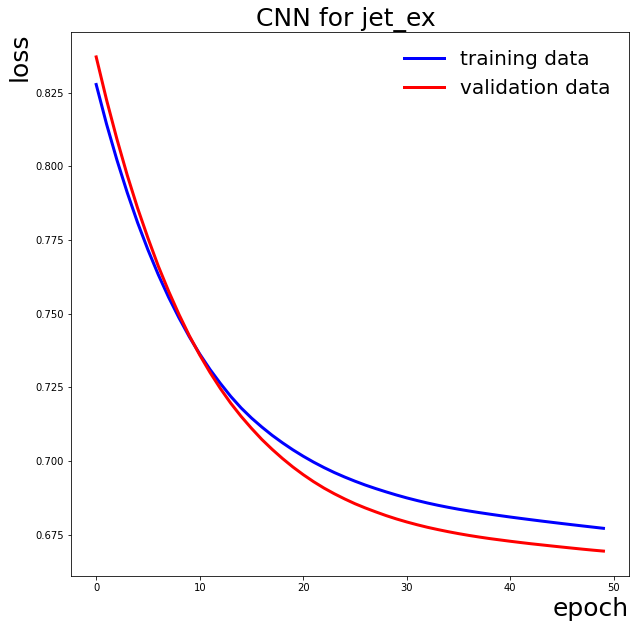



Time Cost : 0.0030 min
Please rise your hand to let TA check your result!!
Quiz 05 is passed!


In [12]:
"""
Please make a learning curve for your training model.
"""
################################################################################################################
#Your code in this section


print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
################################################################################################################

print(History_jet_ex.history.keys())


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(History_jet_ex.history["loss"], label='training data',c='blue',linewidth = 3)
plt.plot(History_jet_ex.history["val_loss"], label='validation data',c='red',linewidth = 3)

plt.title("CNN for jet_ex ", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)


plt.show()

#########################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\n")
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))






################################################################################################################
# Check your result is correct or not.
print("Please rise your hand to let TA check your result!!")
print("Quiz 05 is passed!")

# Example 6 -- Load Model and Check Performance 

Show performance in AUC and ROC.   
In the last few week, we have learnt how to calculate AUC and make ROC plot.   
These two can help to study the performance of this model.
We will make a figure for ROC using the first element in each prediction vector.

Wed Apr 07 05:14:09 2021
Test accuracy is 66.00000262260437


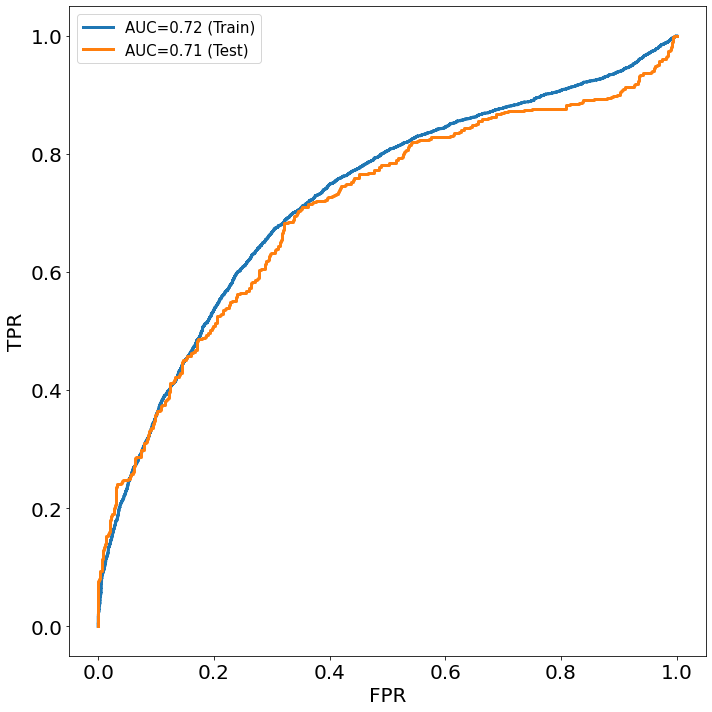



Time Cost : 0.0188 min


In [13]:
"""
Load Model ane Preformance 
"""
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
################################################################################################################
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

   
"""
Load Model
"""
Model_jet = load_model("./model_jet.h5")

"""
Make Prediction for Train and Test Data Set
"""
prediction_train = Model_jet.predict(x_train_jet)
prediction_test = Model_jet.predict(x_test_jet)

"""
Evaluate the model
"""
scores = Model_jet.evaluate(x_test_jet, target_test, verbose=0)
print("Test accuracy is {}".format(scores[1] * 100))


"""
Define axis for ROC
"""  
axis = 0
if axis == 0:
    Class = "W/Z jets"
    other = "Quark jets"
elif axis == 1:
    Class = "Quark jets"
    other = "W/Z jets"

"""
Calculate AUC
"""
auc_train = metrics.roc_auc_score(target_train[:,axis],prediction_train[:,axis])
auc_test = metrics.roc_auc_score(target_test[:,axis],prediction_test[:,axis])


"""
Calculate FPR and TPR
"""
FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(target_train[:,axis],prediction_train[:,axis])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(target_test[:,axis],prediction_test[:,axis])


"""
Generate ROC figure
"""
fig, ax = plt.subplots(1,1, figsize=(10,10))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()



#########################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\n")
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

# Exercise 6 -- Load Model and Check Performance 

Show performance in AUC and ROC.     
Please make a figure for ROC using the first element in each prediction vector.

Test accuracy is 59.20000076293945


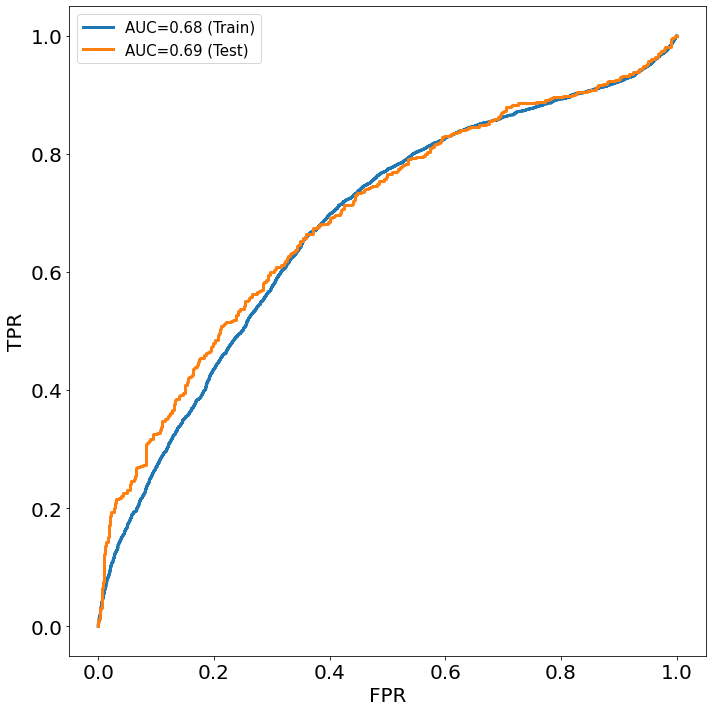



Time Cost : 0.0484 min
Please rise your hand to let TA check your figures!!
Quiz 06 is passed!


In [14]:
"""
Please load your model.
After making prediction for the test data set, please calculate AUC and make a ROC figure.
Please make a figure for ROC using the first element in each prediction vector.
"""
################################################################################################################
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
#Your code in this section

"""
Load Model
"""
Model_jet = load_model("./model_jet_ex.h5")




"""
Make Prediction for training and test data set, respectively
"""

prediction_train = Model_jet.predict(x_train_jet)
prediction_test = Model_jet.predict(x_test_jet)




"""
Evaluate the model
"""

scores = Model_jet.evaluate(x_test_jet, target_test, verbose=0)
print("Test accuracy is {}".format(scores[1] * 100))




"""
Define axis for ROC
"""  
axis = 0
if axis == 0:
    Class = "W/Z jets"
    other = "Quark jets"
elif axis == 1:
    Class = "Quark jets"
    other = "W/Z jets"

"""
Calculate AUC for training and test data set, respectively
"""
auc_train = metrics.roc_auc_score(target_train[:,axis],prediction_train[:,axis])
auc_test = metrics.roc_auc_score(target_test[:,axis],prediction_test[:,axis])


"""
Calculate FPR and TPR for training and test data set, respectively
"""
FalsePositive_train, TruePositive_train, _ = metrics.roc_curve(target_train[:,axis],prediction_train[:,axis])
FalsePositive_test, TruePositive_test, _ = metrics.roc_curve(target_test[:,axis],prediction_test[:,axis])





"""
Generate ROC figure
"""

fig, ax = plt.subplots(1,1, figsize=(10,10))


plt.plot(FalsePositive_train, TruePositive_train,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Train)'.format(auc_train))
plt.plot(FalsePositive_test, TruePositive_test,linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()



#########################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\n")
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))





################################################################################################################
# Check your result is correct or not.
print("Please rise your hand to let TA check your figures!!")
print("Quiz 06 is passed!")